In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from collections import namedtuple
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
# Set the font used for MathJax - more on this later
plt.rc('mathtext',**{'default':'regular'})

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('axes', titlesize=20, titleweight=3)
plt.rc('legend',fontsize='18')
plt.rcParams['legend.title_fontsize'] = '18'
colors = ['black', 'red', 'blue', 'green', 'purple', "brown", "orange", "pink"]
dashes = ['-', ':', '-.', '--', (0, (3, 5, 1, 5, 1, 5)), ":"]
mpl.rcParams['hatch.linewidth'] = 1

In [3]:
carbon_policy_labels = {
    "carbon_waiting": "Lowest-\nWindow",
    "carbon_oracle":  "Lowest-\nWindow*",
    "carbon_lowest": "Lowest-\nSlot",
    "suspend-resume_oracle": "Wait AWhile",
    "suspend-resume-threshold_oracle": "Ecovisor",
    "carbon_cst_oracle": "Carbon-\nTime*",
    "carbon_cst_average": "Carbon-\nTime",
    "cost_oracle": "AllWait-\nThreshold",
    "carbon-cost_cst_average": "RES-First-\nCarbon-Time",
    "carbon-cost_waiting": "RES-First-\nLowest-\nWindow",
    "carbon-spot_cst_average": "Spot-First-\nCarbon-Time",
    "suspend-resume-spot_oracle": "Spot-First-\nWaitAwhile",
    "suspend-resume-spot-threshold_oracle": "Spot-First-\nEcovisor",
    "carbon-cost-spot_cst_average": "SPOT-RES-\nCarbon-Time"
}

carbon_start_index = 7000
task_trace = "pai_1k"
TIME_FACTOR = 5

In [4]:
def color_plot(bar, bars, points, hts = ['/', '//' ,'\\', '-', '.'], 
    cls = ['white', 'lightblue', 'lightpink', 'lightgreen', 'gainsboro']
              ):
    hts = hts[:bars]
    cls = cls[:bars]
    hatches = []
    colors = []
    for p in range(bars):
        for i in range(points):
            hatches.append(hts[p])
            colors.append(cls[p])
    # Loop over the bars
    j = 0
    for i,thisbar in enumerate(bar.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatches[i])
        thisbar.set_ec('black')
        thisbar.set_fc(colors[i])

In [5]:
def change_width(ax, new_value, move_right=0) :
    for patch, line in zip(ax.patches, ax.lines):
        current_width = patch.get_width()

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + move_right)
        
        line.set_xdata(patch.get_x() + patch.get_width() * .5)

In [6]:
def load_task_details(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str):
    if cluster_type =="slurm":
        file_name = f"../results/{cluster_type}/{task_trace}/slurm-details-{scheduling_policy}-{carbon_start_index}-{carbon_policy}-{carbon_trace}-{reserved}-{waiting_times_str}.csv"             
    else:
        file_name = f"../results/{cluster_type}/{task_trace}/details-{scheduling_policy}-{carbon_start_index}-{carbon_policy}-{carbon_trace}-{reserved}-{waiting_times_str}.csv"             
    df = pd.read_csv(file_name)
    df["carbon_policy"] = carbon_policy_labels[scheduling_policy+"_"+carbon_policy]
    df["scheduling_policy"] = scheduling_policy
    df["start_index"] = carbon_start_index
    df["task_trace"] = task_trace    
    return df

In [7]:
def load_task_agg(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str):
    df = load_task_details(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str)
    jobs = df.shape[0]-1
    df =  df.groupby("carbon_policy").sum().reset_index()
    df["scheduling_policy"] = scheduling_policy
    df["start_index"] = carbon_start_index
    df["task_trace"] = task_trace
    df_ = load_task_details(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str)
    df_ = df_[df_["ID"]>=0]
    df["waiting_time"] = df_["waiting_time"].mean()    
    return df

In [8]:
def load_results_breakdown(cluster_type, task_trace, scheduling_policy, carbon_policy, carbon_trace, reserved, waiting_times_str):
    agnostic = load_task_details(cluster_type, task_trace, "carbon", carbon_start_index, "oracle", carbon_trace, 0, "0x0")
    df = load_task_details(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str)
    if cluster_type == "slurm":
        agnostic["ID"] = agnostic["ID"].apply(lambda x:x.split("-")[0])
        agnostic = agnostic[agnostic["ID"]!=""]
        agnostic["ID"] = agnostic["ID"].astype(int)
        df["ID"] = df["ID"].apply(lambda x:x.split("-")[0])
        df = df[df["ID"]!=""]
        df["ID"] = df["ID"].astype(int)
    df = df.join(agnostic,on="ID", rsuffix="_agnostic", how="inner")
   
    if cluster_type == "slurm":
        df["saved_carbon"] = df["total_carbon_cost_agnostic"]  - df["total_carbon_cost"]
        df["saved_cost"] = df["total_dollar_cost_agnostic"]  - df["total_dollar_cost"]
        df["carbon_percent"] = df["saved_carbon"]/df["total_carbon_cost_agnostic"] * 100
        df["cost_percent"] = df["saved_cost"]/df["total_dollar_cost_agnostic"] * 100 
        df["carbon_cost"] = df["total_carbon_cost"]
        df["normalized_carbon"] = df["total_carbon_cost"]/df["total_carbon_cost_agnostic"]
        df = df.dropna()
    else:
        df["saved_carbon"] = df["carbon_cost_agnostic"]  - df["carbon_cost"]
        df["saved_cost"] = df["dollar_cost_agnostic"]  - df["dollar_cost"]
        df["carbon_percent"] = df["saved_carbon"]/df["carbon_cost_agnostic"] * 100
        df["cost_percent"] = df["saved_cost"]/df["dollar_cost_agnostic"] * 100 
        df["normalized_carbon"] = df["carbon_cost"]/df["carbon_cost_agnostic"]
        df = df.dropna()
    df = df[["length", "length_class", "resource_class", "carbon_cost_agnostic","carbon_cost", "saved_carbon", "saved_cost", "carbon_percent","cost_percent", "normalized_carbon"]]
    return df

In [9]:
def load_task_agg_all(cluster_type, task_trace, scheduling_policy, carbon_policy, carbon_trace, reserved, waiting_times_str):
    df = load_task_agg(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str)
    agnostic = load_task_agg(cluster_type, task_trace, "carbon", carbon_start_index, "oracle", carbon_trace, 0, "0x0")
    df["carbon_policy"] = carbon_policy_labels[scheduling_policy+"_"+carbon_policy]
    df["scheduling_policy"] = scheduling_policy
    if cluster_type == "simulation":
        df["saved_carbon"] = agnostic["carbon_cost"]  - df["carbon_cost"]
        df["saved_cost"] = agnostic["dollar_cost"]  - df["dollar_cost"]
        df["carbon_percent"] = df["saved_carbon"]/agnostic["carbon_cost"] * 100
        df["cost_percent"] = df["saved_cost"]/agnostic["dollar_cost"] * 100
        df["normalized_carbon"] = df["carbon_cost"]/agnostic["carbon_cost"]
        df["normalized_cost"] = df["dollar_cost"]/agnostic["dollar_cost"]
    else:
        df["saved_carbon"] = agnostic["total_carbon_cost"]  - df["total_carbon_cost"]
        df["saved_cost"] = agnostic["total_dollar_cost"]  - df["total_dollar_cost"]
        df["carbon_percent"] = df["saved_carbon"]/agnostic["total_carbon_cost"] * 100
        df["cost_percent"] = df["saved_cost"]/agnostic["total_dollar_cost"] * 100
        df["normalized_carbon"] = df["total_carbon_cost"]/agnostic["total_carbon_cost"]
        df["normalized_cost"] = df["total_dollar_cost"]/agnostic["total_dollar_cost"] 
    return df

## Plotting the scheduled jobs

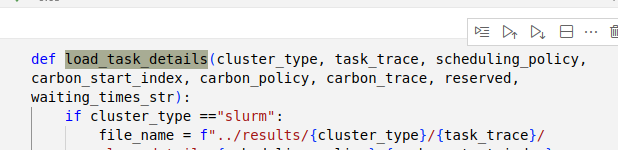

In [48]:
import plotly.express as px
from datetime import datetime
from carbon import get_carbon_model, CarbonModel
import plotly.graph_objects as go
from plotly.subplots import make_subplots

traces = ["test-trace", "pai_1k"]

scheduling_policies = [ 
    # ("carbon", "lowest"),
    # ("carbon", "waiting"),
    # ("carbon", "cst_average"),
    # ("suspend-resume-threshold", "oracle"),
    ("suspend-resume", "oracle")
]


carbon_trace = get_carbon_model("AU-SA", 7000)
start_date_in_carbon_trace_as_timestamp = datetime.fromisoformat(carbon_trace.df.iloc[0]["datetime"]).timestamp()

def time_to_dates(minute) -> str:
    adjusted_timestamp = minute * 60 + start_date_in_carbon_trace_as_timestamp
    return datetime.fromtimestamp(adjusted_timestamp)

# carbon_trace.df["date"] = carbon_trace.df["datetime"].apply(time_to_dates)


for trace in traces:
    
    for policy in scheduling_policies:
        df = load_task_details("simulation", trace, policy[0], 7000, policy[1], "AU-SA", 0, "6x24").sort_values(by=["start_time", "length"])

        df["start_time_date"] = df["start_time"].apply(time_to_dates)
        df["exit_time_date"] = df["exit_time"].apply(time_to_dates)

        min_date_in_trace = time_to_dates(df["start_time"].min())
        max_date_in_trace = time_to_dates(df["exit_time"].max())

        print(min_date_in_trace)
        print(max_date_in_trace)

        fig = px.timeline(df, x_start="start_time_date", x_end="exit_time_date", y="ID")
        fig.show() 

2022-10-19 18:00:00
2022-10-21 01:40:00


2022-10-19 18:00:00
2023-01-31 17:00:00


## Plotting Figure 8.

In [11]:
def plot_policies_carbonwaiting(cluster_type, task_trace, policies, carbon_trace, reserved, waiting_times_str):
    dfs = []
    
    df = load_task_agg_all(cluster_type, task_trace, "carbon", "oracle", carbon_trace, 0, "0x0")
    df["carbon_policy"] = "NoWait"
    dfs.append(df)
    
    for (scheduling, policy) in policies:
        df = load_task_agg_all(cluster_type, task_trace, scheduling, policy, carbon_trace, reserved, waiting_times_str)
        dfs.append(df)
    
    df = pd.concat(dfs).reset_index()
    
    df["normalized_waiting"]= df["waiting_time"]/df["waiting_time"].max()
    
    df = df[["carbon_policy", "normalized_carbon", "normalized_waiting"]]    
    df = df.rename(columns={"normalized_carbon": "Carbon Emissions", "normalized_waiting": "Waiting Time"})
    tidy = df.melt(id_vars='carbon_policy').rename(columns=str.title)
    
    
    fig, ax = plt.subplots(ncols= 1, nrows=1, figsize=(8,3))
    
    bar = sns.barplot(x='Carbon_Policy', y='Value', hue='Variable', data=tidy, ax=ax, ec="black", lw=2)
    
    color_plot(bar, 3,len(dfs), hts=['/', '\\', '-', '.'], cls=['white', 'lightpink', 'lightgreen', 'gainsboro'])
    ax.set_ylim(0,1)
    ax.set_yticks([0, .25, .5, .75, 1])
    
    ax.set_ylabel("Normalized Metric", fontsize=19)
    ax.set_xlabel("")
    sns.despine(fig)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.tight_layout()
    
    ax.legend(title=None, loc="upper center", fontsize=16, ncol=3, bbox_to_anchor=(0.5, 1.3))
    return df#[["carbon_policy", "carbon_percent", "waiting_time"]]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


,carbon_policy,Carbon Emissions,Waiting Time
0,NoWait,1.000000,0.000000
1,Lowest-\nSlot,0.779873,0.628936
2,Lowest-\nWindow,0.683560,0.741279
3,Carbon-\nTime,0.724736,0.527541
4,Ecovisor,0.638971,0.872427
5,Wait AWhile,0.546081,1.000000


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


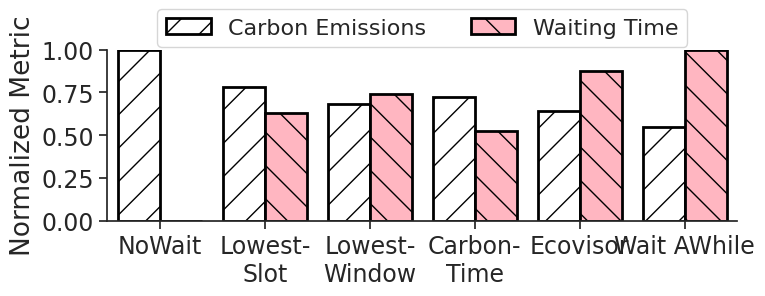

In [12]:
cluster_type = "simulation"
carbon_trace = "AU-SA"
policies = [ 
    ("carbon", "lowest"),
    ("carbon", "waiting"),
    ("carbon", "cst_average"),
    ("suspend-resume-threshold", "oracle"),
    ("suspend-resume", "oracle")
]

plot_policies_carbonwaiting(cluster_type, task_trace, policies, carbon_trace, 0, "6x24")

## Plot Figure 9.

In [13]:
def plot_carbon_percent_length_CDF(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, reserved, waiting_times_str):
    df = load_results_breakdown(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, reserved, waiting_times_str)
    df["length"]//=12 # We use 5X, so we divide the time by 12 to make it minutes
    df = df.groupby("length").sum().reset_index()
    df = df.sort_values(by = "length").reset_index()
    df["carbon_cum"] = df["saved_carbon"].cumsum()
    df["carbon_cum"]/= df["carbon_cum"].values[-1]
    
    fig, ax = plt.subplots(ncols= 1, nrows=1, figsize=(8,3))
    
    sns.lineplot(data=df, y="carbon_cum", x="length", ax=ax, color="black", lw=2.5)
    ax.set_xscale('log')
    ax.set_ylim(0, 1)
    ax.set_yticks([0,.25,.5,.75,1])
    ax.set_xlim(5, 3579)
    ax.set_xticks([5, 60, 60*3,60*12, 3579])    
    ax.set_xticklabels(["5mins", "1hr", "3hrs", "12hrs", "60hrs"], fontsize=18)
    ax.set_xlabel("Job Length")
    ax.set_ylabel("Normalized Total\nCarbon Reduction\n(CDF)")
    
    sns.despine(fig)

    plt.tight_layout()
    return df

,index,length,carbon_cost_agnostic,carbon_cost,saved_carbon,saved_cost,carbon_percent,cost_percent,normalized_carbon,carbon_cum
0,0,5,1.330658,1.079773,0.250885,0.002600,1060.052262,38.339380,53.399477,0.001621
1,1,6,0.960493,0.781967,0.178526,0.001473,781.658657,18.917858,34.183413,0.002774
2,2,7,1.094676,0.871899,0.222777,0.001491,752.490396,15.550884,27.475096,0.004214
3,3,8,0.713735,0.555753,0.157981,0.000815,510.949239,8.985692,21.890508,0.005234
4,4,9,0.523617,0.421951,0.101666,0.000745,313.583562,7.075343,17.864164,0.005891
...,...,...,...,...,...,...,...,...,...,...
330,330,1961,7.834038,4.824868,3.009170,0.000017,38.411483,0.000850,0.615885,0.972114
331,331,2378,2.356082,1.860012,0.496070,0.000035,21.054861,0.001401,0.789451,0.975319
332,332,2605,19.432340,18.848788,0.583552,0.000000,3.002994,0.000000,0.969970,0.979089
333,333,2880,21.298463,21.862510,-0.564047,0.000035,-2.648299,0.000579,1.026483,0.975445


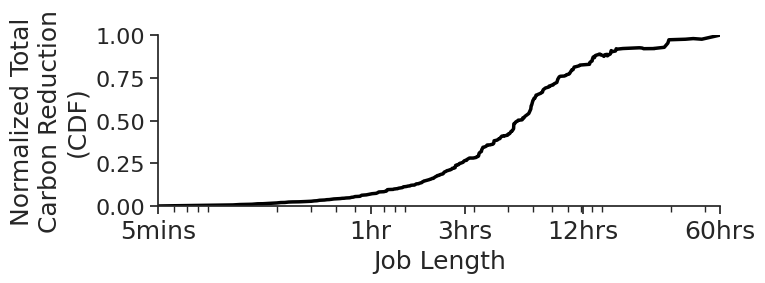

In [14]:
cluster_type = "simulation"
carbon_trace = "AU-SA"
policy = "cst_average"
plot_carbon_percent_length_CDF(cluster_type, task_trace, "carbon", policy, carbon_trace, 0, "6x24")

## Plot Figure 10

In [15]:
def plot_cost_percent_clustertraces(cluster_type, policies, carbon_trace, waiting_times, reserved):
    dfs = []
    df = load_task_agg_all(cluster_type, task_trace, "carbon", "oracle", carbon_trace, reserved, "0x0")
    df["carbon_policy"] = "NoWait"
    dfs.append(df)
    
    for (scheduling_policy, policy) in policies:
        df = load_task_agg_all(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, reserved, waiting_times)
        dfs.append(df)    

    df = pd.concat(dfs).reset_index()
    
    df["normalized_waiting"]= df["waiting_time"]/df["waiting_time"].max()
    df["normalized_carbon"]= df["normalized_carbon"]/df["normalized_carbon"].max()
    df["normalized_cost"]= df["normalized_cost"]/df["normalized_cost"].max()
    
    df = df[["carbon_policy", "normalized_carbon", "normalized_cost", "normalized_waiting"]]    
    df = df.rename(columns={"normalized_carbon": "Carbon Emissions", "normalized_cost": "Cost", "normalized_waiting": "Waiting Time"})
    tidy = df.melt(id_vars='carbon_policy').rename(columns=str.title)
    
    fig, ax = plt.subplots(ncols= 1, nrows=1, figsize=(8,3))
    
    bar = sns.barplot(x='Carbon_Policy', y='Value', hue='Variable', data=tidy, ax=ax, ec="black", lw=2)
    
    color_plot(bar, 3,len(dfs))
    
    ax.set_ylim(0,1)
    ax.set_yticks([0, .25, .5, .75, 1])
    
    ax.set_ylabel("Normalized Metric")
    ax.set_xlabel("")
    sns.despine(fig)
    plt.tight_layout()
    ax.legend(title=None, loc="upper center", fontsize=16, ncol=3, bbox_to_anchor=(0.5, 1.32))
    return tidy

,Carbon_Policy,Variable,Value
0,NoWait,Carbon Emissions,1.000000
1,AllWait-\nThreshold,Carbon Emissions,0.921652
2,Wait AWhile,Carbon Emissions,0.546196
3,Ecovisor,Carbon Emissions,0.639105
4,Carbon-\nTime,Carbon Emissions,0.724888
5,RES-First-\nCarbon-Time,Carbon Emissions,0.854406
6,NoWait,Cost,0.813706
7,AllWait-\nThreshold,Cost,0.684217
8,Wait AWhile,Cost,1.000000
9,Ecovisor,Cost,0.952406


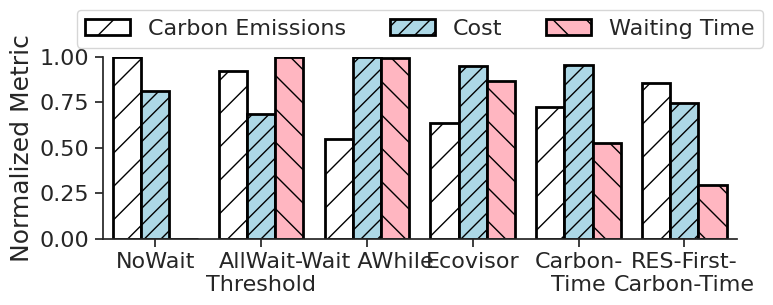

In [16]:
cluster_type="simulation"
carbon_trace = "AU-SA"
reserved = 9
policies = [ 
    ("cost", "oracle"),
    ("suspend-resume", "oracle"),
    ("suspend-resume-threshold", "oracle"),
    ("carbon", "cst_average"),
    ("carbon-cost", "cst_average"),
]
waiting_times="6x24"
plot_cost_percent_clustertraces(cluster_type=cluster_type,policies=policies, carbon_trace=carbon_trace, waiting_times=waiting_times, reserved=reserved)

## Plot Figure 11

In [17]:
def plot_carbon_cost(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, waiting_times_str):
    dfs = []
    for reserved in [0, 3, 6, 9, 12, 15, 18, 21, 24]:
        try:
            if reserved == 0:
                df = load_task_agg_all(cluster_type, task_trace, "carbon", policy, carbon_trace, reserved, waiting_times_str)
            else:
                df = load_task_agg_all(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, reserved, waiting_times_str)
            df["reserved"] = reserved
            dfs.append(df)
        except:
            pass
    df = pd.concat(dfs).reset_index()
    df["waiting_time"] /= 720
    fig, ax = plt.subplots(ncols= 1, nrows=1, figsize=(8,3))
    sns.lineplot(x="reserved", y="normalized_cost", data=df, color="black", ax=ax, lw=2, ms=10,ls="--",
                label="Cost"
               )    
        
    ax.set_xlabel("Reserved Instances")
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 3))

    sns.lineplot(
        x="reserved", y="normalized_carbon", data=df, color="brown", lw=2, ms=6,ls="-",
        ax = ax,
                label=r"Carbon Emissions"
        
    )
    ax.legend(loc="center right", 
              fontsize=18,ncol=1)
    
    ax.set_ylim([0.5, 1])
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.tick_params(axis='y', colors="black")
    ax.set_ylabel("Normalized Metric",  fontsize=15)
    ax2 = ax.twinx()
    
    sns.lineplot(
        x="reserved", y="waiting_time", data=df, color="red", ls=":", lw=2, ms=6,
        ax = ax2,
                label=r"Waiting Time"
        
    )
    ax2.set_ylim(0, 5)
    ax2.set_yticks(range(0, 6, 1))
    
    ax2.tick_params(axis='y', colors="black")
    ax2.set_ylabel("Waiting Time (hour)", fontsize=15)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=16)
    
    sns.despine(fig, right=False)
    plt.tight_layout()
    
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1+handles2, labels1+labels2,
              loc="center right", 
              fontsize=14,ncol=1, borderaxespad=0)
    
    ax2.legend().remove()
    return df
    


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


,index,carbon_policy,ID,arrival_time,length,cpus,carbon_cost,dollar_cost,start_time,waiting_time,...,start_index,scheduling_policy,task_trace,saved_carbon,saved_cost,carbon_percent,cost_percent,normalized_carbon,normalized_cost,reserved
0,0,Carbon-\nTime,499499,61374633,1812837,1236,407.511325,199.175860,64779513,4.729000,...,7000,carbon,pai_1k,154.778247,0.040855,27.526430,0.020508,0.724736,0.999795,0
1,0,RES-First-\nCarbon-Time,499499,61374633,1812837,1236,436.434616,178.261269,64332273,4.107833,...,7000,carbon-cost,pai_1k,125.854956,20.955445,22.382588,10.518919,0.776174,0.894811,3
2,0,RES-First-\nCarbon-Time,499499,61374633,1812837,1236,458.996838,159.717792,63738153,3.282667,...,7000,carbon-cost,pai_1k,103.292734,39.498923,18.370025,19.827113,0.816300,0.801729,6
3,0,RES-First-\nCarbon-Time,499499,61374633,1812837,1236,480.322255,142.148535,63278080,2.643676,...,7000,carbon-cost,pai_1k,81.967317,57.068180,14.577421,28.646281,0.854226,0.713537,9
4,0,RES-First-\nCarbon-Time,499499,61374633,1812837,1236,499.898230,124.225123,62864286,2.068963,...,7000,carbon-cost,pai_1k,62.391342,74.991592,11.095945,37.643223,0.889041,0.623568,12
5,0,RES-First-\nCarbon-Time,499499,61374633,1812837,1236,521.492397,108.940347,62411578,1.440201,...,7000,carbon-cost,pai_1k,40.797175,90.276368,7.255545,45.315659,0.927445,0.546843,15
6,0,RES-First-\nCarbon-Time,499499,61374633,1812837,1236,540.444626,106.546111,62082424,0.983043,...,7000,carbon-cost,pai_1k,21.844946,92.670604,3.884999,46.517484,0.961150,0.534825,18
7,0,RES-First-\nCarbon-Time,499499,61374633,1812837,1236,550.879753,109.023581,61833768,0.637687,...,7000,carbon-cost,pai_1k,11.409820,90.193133,2.029171,45.273878,0.979708,0.547261,21
8,0,RES-First-\nCarbon-Time,499499,61374633,1812837,1236,556.380473,110.262065,61724487,0.485908,...,7000,carbon-cost,pai_1k,5.909099,88.954649,1.050900,44.652202,0.989491,0.553478,24


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


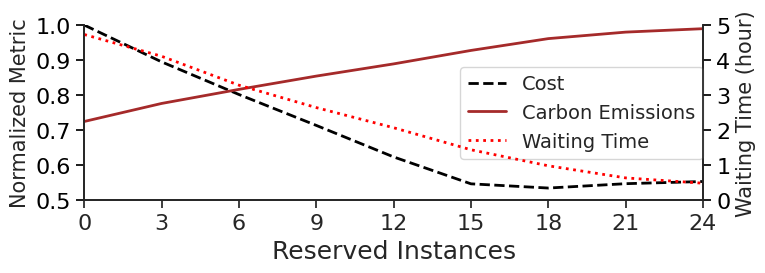

In [18]:
cluster_type = "simulation"
carbon_trace = "AU-SA"
plot_carbon_cost(cluster_type, task_trace, "carbon-cost", "cst_average", carbon_trace, "6x24")

# Figure 12

In [19]:
def plot_spot(cluster_type, policies, carbon_trace, waiting_times_str):
    dfs = []
    
    for (scheduling_policy, policy, reserved) in policies:
        df = load_task_agg_all(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, reserved, waiting_times_str)        
        df["carbon_policy"] = carbon_policy_labels[scheduling_policy+"_"+policy] +f"\n({reserved})"
        dfs.append(df)
    
    df = pd.concat(dfs).reset_index()
    
    
    df["normalized_waiting"]= df["waiting_time"]/df["waiting_time"].max()
    df["normalized_carbon"]= df["normalized_carbon"]/df["normalized_carbon"].max()
    df["normalized_cost"]= df["normalized_cost"]/df["normalized_cost"].max()
    
    df = df[["carbon_policy", "normalized_carbon", "normalized_cost", "normalized_waiting"]]   
    df = df.rename(columns={"normalized_carbon": "Carbon Emissions", "normalized_cost": "Cost", "normalized_waiting":"Waiting"})
    tidy = df.melt(id_vars='carbon_policy').rename(columns=str.title)
    fig, ax = plt.subplots(ncols= 1, nrows=1, figsize=(8,3))
    
    bar = sns.barplot(x='Carbon_Policy', y='Value', hue='Variable', data=tidy, ax=ax, ec="black", lw=2)
    color_plot(bar, 3,len(dfs))
    ax.set_ylim(0,1)
    ax.set_yticks([0,.25,.5,.75,1])
    
    ax.set_ylabel("Normalized Metric")
    ax.set_xlabel("")
    sns.despine(fig)
    plt.tight_layout()
    ax.legend(title=None, loc="upper center", fontsize=16, ncol=3, bbox_to_anchor=(0.5, 1.32))
    return tidy

,Carbon_Policy,Variable,Value
0,Carbon-\nTime\n(0),Carbon Emissions,0.841222
1,Spot-First-\nCarbon-Time\n(0),Carbon Emissions,0.841222
2,Spot-First-\nEcovisor\n(0),Carbon Emissions,0.741672
3,SPOT-RES-\nCarbon-Time\n(9),Carbon Emissions,1.000000
4,SPOT-RES-\nCarbon-Time\n(6),Carbon Emissions,0.942510
5,Carbon-\nTime\n(0),Cost,1.000000
6,Spot-First-\nCarbon-Time\n(0),Cost,0.858983
7,Spot-First-\nEcovisor\n(0),Cost,0.858983
8,SPOT-RES-\nCarbon-Time\n(9),Cost,0.589779
9,SPOT-RES-\nCarbon-Time\n(6),Cost,0.666424


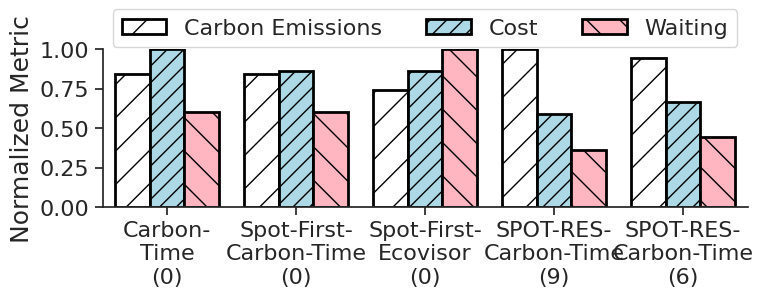

In [20]:
cluster_type="simulation"
carbon_trace = "AU-SA"
policies = [ 
    ("carbon", "cst_average", 0),
    ("carbon-spot", "cst_average", 0),
    ("suspend-resume-spot-threshold","oracle", 0),
    ("carbon-cost-spot", "cst_average", 9),
    ("carbon-cost-spot", "cst_average", 6),
    
]
waiting_times_str="6x24"
plot_spot(cluster_type="simulation",policies=policies, carbon_trace=carbon_trace, waiting_times_str=waiting_times_str)